# Building a Neural Network from Scratch

http://jonathanweisberg.org/post/A%20Neural%20Network%20from%20Scratch%20-%20Part%201/


In this post we’re going to build a neural network from scratch. We’ll train it to recognize hand-written digits, using the famous MNIST data set.

We’ll use just basic Python with NumPy to build our network (no high-level stuff like Keras or TensorFlow). We will dip into scikit-learn, but only to get the MNIST data and to assess our model once its built.

---

#  (Fashion MNIST)
## data:  70000

In [1]:
import time
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [2]:
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [3]:
path = '/Users/reshamashaikh/ds/my_repos/pytorch_work/data_fashion/'
#path = '/Users/reshamashaikh/ds/my_repos/fashion_mnist/raw'

In [4]:
!ls -alt {path}

total 171304
drwxr-xr-x  22 reshamashaikh  staff       704 Sep  9 17:33 ..
-rw-r--r--@  1 reshamashaikh  staff      6148 Aug 31 22:59 .DS_Store
drwxr-xr-x  11 reshamashaikh  staff       352 Aug 31 22:59 .
-rw-r--r--   1 reshamashaikh  staff     10008 Aug 31 22:59 t10k-labels-idx1-ubyte
-rw-r--r--   1 reshamashaikh  staff     60008 Aug 31 22:58 train-labels-idx1-ubyte
-rw-r--r--   1 reshamashaikh  staff  47040016 Aug 31 22:58 train-images-idx3-ubyte
-rw-r--r--   1 reshamashaikh  staff   7840016 Aug 31 22:58 t10k-images-idx3-ubyte
-rw-r--r--@  1 reshamashaikh  staff      5148 Aug 31  2017 t10k-labels-idx1-ubyte.gz
-rw-r--r--@  1 reshamashaikh  staff   4422102 Aug 31  2017 t10k-images-idx3-ubyte.gz
-rw-r--r--@  1 reshamashaikh  staff     29515 Aug 31  2017 train-labels-idx1-ubyte.gz
-rw-r--r--@  1 reshamashaikh  staff  26421880 Aug 31  2017 train-images-idx3-ubyte.gz


In [5]:
X_train, Y_train = load_mnist(path, kind='train')
X_test, Y_test = load_mnist(path, kind='t10k')

In [6]:
print(type(X_train))
print(X_train.shape)

print(type(Y_train))
print(Y_train.shape)

print(type(X_test))
print(X_test.shape)

print(type(Y_test))
print(Y_test.shape)

<class 'numpy.ndarray'>
(60000, 784)
<class 'numpy.ndarray'>
(60000,)
<class 'numpy.ndarray'>
(10000, 784)
<class 'numpy.ndarray'>
(10000,)


In [7]:
t0 = time.time()

In [8]:
# from sklearn.datasets import fetch_mldata

# mnist = fetch_mldata('MNIST original')
# X, y = mnist["data"], mnist["target"]

In [9]:
# We’ll normalize the data to keep our gradients manageable:

X_train = X_train / 255
X_test = X_test / 255

In [10]:
X_train = np.transpose(X_train)
X_test = np.transpose(X_test)

print(type(X_train))
print(X_train.shape)

print(type(X_test))
print(X_test.shape)

<class 'numpy.ndarray'>
(784, 60000)
<class 'numpy.ndarray'>
(784, 10000)


In [11]:
# Then we’ll one-hot encode MNIST’s labels, to get a 10 x 70,000 array.
digits = 10
m = 60000

def encode_labels(y, logp):
    #digits = 10
    examples = y.shape[0]

    print('-'*20)
    print(y.shape)
    y = y.reshape(1, examples)
    if logp == 1:
        print(type(y))
        print(y.shape)

    Y_new = np.eye(digits)[y.astype('int32')]
    if logp == 1:
        print(type(Y_new))
        print(Y_new.shape)

    Y_new = Y_new.T.reshape(digits, examples)
    if logp == 1:
        print(type(Y_new))
        print(Y_new.shape)
        
    return Y_new

Y_train = encode_labels(Y_train, 1)
Y_test = encode_labels(Y_test, 1)

--------------------
(60000,)
<class 'numpy.ndarray'>
(1, 60000)
<class 'numpy.ndarray'>
(1, 60000, 10)
<class 'numpy.ndarray'>
(10, 60000)
--------------------
(10000,)
<class 'numpy.ndarray'>
(1, 10000)
<class 'numpy.ndarray'>
(1, 10000, 10)
<class 'numpy.ndarray'>
(10, 10000)


In [15]:
print(type(X_train))
print(X_train.shape)

print(type(Y_train))
print(Y_train.shape)

<class 'numpy.ndarray'>
(784, 60000)
<class 'numpy.ndarray'>
(10, 60000)


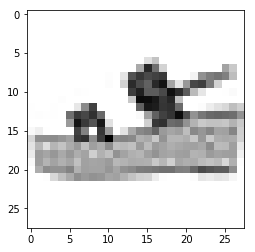

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

In [16]:
# A quick check that things are as they should be:

i = 12
plt.imshow(X_train[:,i].reshape(28,28), cmap = matplotlib.cm.binary)
plt.axis("on")
plt.show()
Y_train[:,i]

In [17]:
#So let’s define:

def compute_multiclass_loss(Y, Y_hat):

    L_sum = np.sum(np.multiply(Y, np.log(Y_hat)))
    m = Y.shape[1]
    L = -(1/m) * L_sum

    return L

In [18]:
def sigmoid(z):
    s = 1 / (1 + np.exp(-z))
    return s

### one hidden layer

In [19]:
# 4.5 Build & Train

n_x = X_train.shape[0]
n_h = 64
learning_rate = 1

W1 = np.random.randn(n_h, n_x)
b1 = np.zeros((n_h, 1))
W2 = np.random.randn(digits, n_h)
b2 = np.zeros((digits, 1))

X = X_train
Y = Y_train

for i in range(2000):

    Z1 = np.matmul(W1,X) + b1
    A1 = sigmoid(Z1)
    Z2 = np.matmul(W2,A1) + b2
    A2 = np.exp(Z2) / np.sum(np.exp(Z2), axis=0)

    cost = compute_multiclass_loss(Y, A2)

    dZ2 = A2-Y
    dW2 = (1./m) * np.matmul(dZ2, A1.T)
    db2 = (1./m) * np.sum(dZ2, axis=1, keepdims=True)

    dA1 = np.matmul(W2.T, dZ2)
    dZ1 = dA1 * sigmoid(Z1) * (1 - sigmoid(Z1))
    dW1 = (1./m) * np.matmul(dZ1, X.T)
    db1 = (1./m) * np.sum(dZ1, axis=1, keepdims=True)

    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1

    if (i % 100 == 0):
        print("Epoch", i, "cost: ", cost)

print("Final cost:", cost)

Epoch 0 cost:  6.610702254862646
Epoch 100 cost:  0.9620180315785246
Epoch 200 cost:  0.8402263067690293
Epoch 300 cost:  0.7811708527971
Epoch 400 cost:  0.7274272068968991
Epoch 500 cost:  0.6830446177948594
Epoch 600 cost:  0.6458801818990421
Epoch 700 cost:  0.6167941729027928
Epoch 800 cost:  0.5944074476825082
Epoch 900 cost:  0.5766117413261572
Epoch 1000 cost:  0.5610676746377082
Epoch 1100 cost:  0.5477173361745385
Epoch 1200 cost:  0.5357986955550329
Epoch 1300 cost:  0.5250015240908327
Epoch 1400 cost:  0.5151646163432007
Epoch 1500 cost:  0.506175718518084
Epoch 1600 cost:  0.4979345955512209
Epoch 1700 cost:  0.49034768891299363
Epoch 1800 cost:  0.4833300307074315
Epoch 1900 cost:  0.47680751291267565
Final cost: 0.4644229896951908


In [20]:
from sklearn.metrics import classification_report, confusion_matrix

In [21]:
# Let’s see how we did:

Z1 = np.matmul(W1, X_test) + b1
A1 = sigmoid(Z1)
Z2 = np.matmul(W2, A1) + b2
A2 = np.exp(Z2) / np.sum(np.exp(Z2), axis=0)

predictions = np.argmax(A2, axis=0)
labels = np.argmax(Y_test, axis=0)

index = 0
misclassifiedIndexes = []
for label, predict in zip(labels, predictions):
    if label != predict: 
        misclassifiedIndexes.append(index)
    index +=1

print(confusion_matrix(predictions, labels))
print(classification_report(predictions, labels))

[[863   7  30  53   1   0 263   0   8   1]
 [  5 952   1  24   2   1   0   0   2   0]
 [ 22   5 751  21 149   0 167   0  24   0]
 [ 56  28   8 841  31   0  50   0   5   0]
 [ 10   3 148  49 786   0 157   0  11   0]
 [  3   0   2   1   2 899   0  33   6  19]
 [ 24   3  46   9  23   0 328   0   4   0]
 [  1   0   0   0   0  57   0 909  12  46]
 [ 16   2  13   2   6  10  35   2 928   5]
 [  0   0   1   0   0  33   0  56   0 929]]
             precision    recall  f1-score   support

          0       0.86      0.70      0.78      1226
          1       0.95      0.96      0.96       987
          2       0.75      0.66      0.70      1139
          3       0.84      0.83      0.83      1019
          4       0.79      0.68      0.73      1164
          5       0.90      0.93      0.92       965
          6       0.33      0.75      0.46       437
          7       0.91      0.89      0.90      1025
          8       0.93      0.91      0.92      1019
          9       0.93      0.91      

In [22]:
print(len(misclassifiedIndexes))

1814


In [23]:
print("Accuracy:  ", 1 - (len(misclassifiedIndexes)/10000))

Accuracy:   0.8186
